In [1]:
'''
    Title: Generative Adversarial Networks to approximate a 1D Gaussian Distribution
    Author: Luckyson Khaidem
    Date: 2017-07-31
'''
import numpy as np 
import tensorflow as tf 
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
np.random.seed(0)
tf.set_random_seed(0)
#Distribution of the training data
class DataDistribution:
    def __init__(self,mu, sigma):
        self.mu = mu
        self.sigma = sigma
    def samples(self, N):
        return np.random.normal(self.mu, self.sigma,N)

In [3]:
def plot_data_distribution():
    distribution = DataDistribution(4,0.5)
    samples = distribution.samples(1000)
    samples = pd.Series(samples)
    samples.plot(kind="density")
    plt.grid(True)
    plt.show()

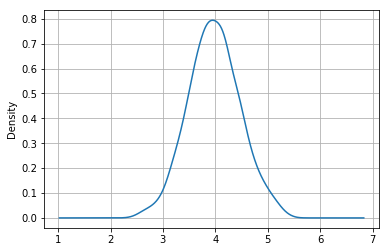

In [4]:
#Plots the density curve of the training data that the generator tries to estimate
plot_data_distribution()

In [5]:
#Noisy signal which serves as an input to the generator
class GeneratorNoiseDistribution:
    def __init__(self,limit):
        self.limit = limit
    def sample_noise(self,N):
        return np.linspace(-self.limit, self.limit,N) + np.random.random() * 0.001

In [6]:
def plot_noise_distribution():
    distribution = GeneratorNoiseDistribution(8)
    samples = distribution.sample_noise(1000)
    samples = pd.Series(samples)
    samples.plot(kind = "density")
    plt.grid(True)
    plt.show()

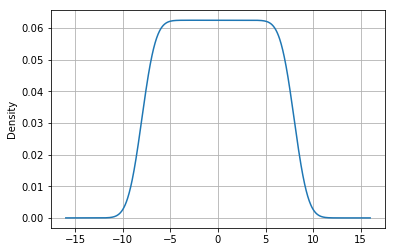

In [7]:
#plots the distribution of the input to the generator
plot_noise_distribution()

In [8]:
class Model:
    def __init__(self):
        pass
    def new_weights(self, shape, name):
        return tf.Variable(tf.truncated_normal(shape, stddev = 1.0), name = name)
    def new_biases(self, length, name):
        return tf.Variable(tf.constant(0.0, shape = [length]), name = name)
    def linear(self, data_input,weights, biases):
        return tf.matmul(data_input, weights) + biases

In [9]:
class Generator(Model):
    def __init__(self,num_input_neurons,num_hidden_neurons,num_output_neurons):
        self.num_input_neurons = num_input_neurons
        self.num_hidden_neurons = num_hidden_neurons
        self.num_output_neurons = num_output_neurons
    def get_output(self,x):
        w1 = self.new_weights([self.num_input_neurons,self.num_hidden_neurons],"w1")
        b1 = self.new_biases(self.num_hidden_neurons,"b1")
        w2 = self.new_weights([self.num_hidden_neurons, self.num_output_neurons],"w2")
        b2 = self.new_biases(self.num_output_neurons,"b2")   
        layer_1 = tf.nn.softplus(self.linear(x, w1, b1))
        layer_2 = self.linear(layer_1,w2,b2)
        return layer_2              

In [10]:
class Discriminator(Model):
    def __init__(self,num_input_neurons,num_hidden_neurons,num_output_neurons):
        self.num_input_neurons = num_input_neurons
        self.num_hidden_neurons = num_hidden_neurons
        self.num_output_neurons = num_output_neurons
    def get_output(self,x):
        w1 = self.new_weights([self.num_input_neurons,self.num_hidden_neurons],"w1")
        b1 = self.new_biases(self.num_hidden_neurons,"b1")
        w2 = self.new_weights([self.num_hidden_neurons, self.num_hidden_neurons],"w2")
        b2 = self.new_biases(self.num_hidden_neurons,"b2")
        w3 = self.new_weights([self.num_hidden_neurons, self.num_hidden_neurons],"w3")
        b3 = self.new_biases(self.num_hidden_neurons,"b3")
        w4 = self.new_weights([self.num_hidden_neurons, self.num_output_neurons],"w4")
        b4 = self.new_biases(self.num_output_neurons,"b4")
        layer_1 = tf.nn.relu(self.linear(x, w1, b1))
        layer_2 = tf.nn.relu(self.linear(layer_1,w2,b2))
        layer_3 = tf.nn.relu(self.linear(layer_2,w3,b3))
        layer_4 = tf.sigmoid(self.linear(layer_3,w4,b4))
        return layer_4

In [11]:
def log(x):
    return tf.log(tf.maximum(x,1e-5))

In [12]:
G = Generator(1,8,1)
D = Discriminator(1,8,1)
x_d = tf.placeholder(tf.float32, [None,1])
x_g = tf.placeholder(tf.float32, [None,1])
g_output = G.get_output(x_g)
d1 = D.get_output(x_d)
d2 = D.get_output(g_output)
loss_d = tf.reduce_mean(-log(d1) - (1 - d2))
loss_g = tf.reduce_mean(-log(d2))

In [13]:
initial_learning_rate = 0.05
decay = 0.95
num_decay_steps = 1000
global_step = tf.Variable(0, trainable = True)
learning_rate = tf.train.exponential_decay(initial_learning_rate,global_step,num_decay_steps, decay, staircase = True)
train_d = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_d)
train_g = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_g)

In [14]:
def gen_data_sample(batch_size):
    return DataDistribution(0,1).samples(batch_size).reshape((-1,1))
def gen_noise_sample(batch_size):
    return GeneratorNoiseDistribution(8).sample_noise(batch_size).reshape((-1,1))

In [15]:
epoch = 1000
batch_size = 8
session = tf.Session()

In [17]:
def optimize(epoch, batch_size):
    for i in xrange(epoch):
        session.run(tf.global_variables_initializer())
        d_input = gen_data_sample(batch_size)
        z_noise = gen_noise_sample(batch_size)
       
        session.run(train_d, { x_d: d_input,
                                   x_g: z_noise})
        z_noise = gen_noise_sample(batch_size)
        session.run(train_g, {x_g: z_noise})
        loss_discriminator, loss_generator = session.run([loss_d, loss_g], {
                                                x_d: d_input,
                                                x_g: z_noise})
        if i % 100 == 0:
            print "Step: {},Discriminator Loss: {}, Generator Loss: {}".format(i, loss_discriminator, loss_generator)
       

In [18]:
optimize(epoch,batch_size)

Step: 0,Discriminator Loss: -0.103443928063, Generator Loss: 0.473234772682
Step: 100,Discriminator Loss: 0.209404557943, Generator Loss: 0.00109645840712
Step: 200,Discriminator Loss: 2.19780921936, Generator Loss: 0.0689159408212
Step: 300,Discriminator Loss: 0.469748228788, Generator Loss: 2.53319967669e-07
Step: 400,Discriminator Loss: 0.161557167768, Generator Loss: 0.0866968780756
Step: 500,Discriminator Loss: 0.0436147600412, Generator Loss: 2.98290681839
Step: 600,Discriminator Loss: 2.29323172569, Generator Loss: 0.686817228794
Step: 700,Discriminator Loss: 0.176911205053, Generator Loss: 0.0624210461974
Step: 800,Discriminator Loss: 0.364373356104, Generator Loss: 0.078822158277
Step: 900,Discriminator Loss: 0.197254657745, Generator Loss: 0.00105916755274


In [19]:
def plot_result():
    real_data = pd.Series(gen_data_sample(1000).ravel())
    generated_data = pd.Series( session.run(g_output,{x_g: gen_noise_sample(1000)}).ravel())
    real_data.plot(kind = "density", label = "real data")
    generated_data.plot(kind = "density", label = "generated data")
    noise = pd.Series(gen_noise_sample(1000).ravel())
    noise.plot(kind = "density", label = "input noise")
    plt.legend(loc = "upper right")
    plt.show()

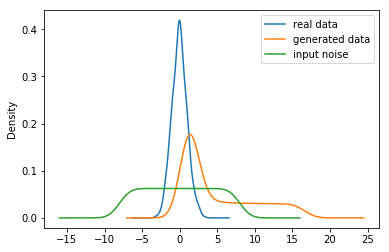

In [20]:
plot_result()

In [21]:
session.close()